# 어강(악상어목, 당멸치목, 총기어목) COI 염기서열 추출 후 군집화(Alignment 과정 x + 비지도학습)

## 데이터 수집 자동 크롤러를 위한 함수들(getOrganism() -> getGenbank())

In [1]:
#[220505_1137]UPDATED 지금까지 구성을 전부 정리함
from Bio import Entrez, SeqIO, AlignIO
from Bio.Align.Applications import MuscleCommandline
from pathlib import Path
from Bio import GenBank
from Bio.SeqUtils import GC

Entrez.email = "nagabuti13@naver.com"

#[220502_1717]CREATED getIdList: NCBI에서 keyword를 검색하여 script의 id를 추출한다
#[220512_1210]NOTED esearch()의 파라미터에 id의 개수를 조절하는 retmax 파라미터가 존재
def getIdlist(database, keyword):
    handle = Entrez.esearch(db = database, retmax = 10000, term = keyword)
    records = Entrez.read(handle)
    return records["IdList"]

#[220505_1717]CREATED getFastaFile: NCBI에서 id를 검색하여 얻은 fasta파일을 컴퓨터에 저장한다
def getFasta(id):
    handle = Entrez.efetch(db = 'nucleotide', id = id, rettype = 'fasta', retmode = 'text')
    record = SeqIO.read(handle, 'fasta')
    print('## creating ' + record.id + '.fasta...')
    with open(record.id + '.fasta', 'w') as f:
        f.write('>' + record.description + '\n')
        f.write(str(record.seq) + '\n')
    
#[220502_1717]CREATED getAlnFile: 다중염기서열을 생성하는 툴 중 하나인 MUSCLE로 aln파일을 생성한다
def getAln(filename):
    muscle_exe = '/Users/kimjoonsu/muscle3.8.31_i86darwin64'
    cmd_line = MuscleCommandline(muscle_exe, input = filename,
                             out = Path(filename).stem + '.aln', clw = ' ')
    print(cmd_line)
    stdout, stderr = cmd_line()   
    
#[220509_1517]CREATED ncbi에서 alignment의 각 record genbank파일로부터 종 이름을 반환
def getGenbank(id):
    handle = Entrez.efetch(db = "nucleotide", rettype = "gb", id = id, retmode = "text")
    r = GenBank.read(handle)
    #[220811_1431]NOTED getOrganism() -> getGenbank()
    return r

In [2]:
#[220505_2320]CREATED 차레대로 토끼, 쥐, 다람쥐의 COI 염기서열 종 목록
#[220520_0628]CREATED 종 9개로 제한
#[220811_1321]CREATED 9개의 종을 쿼리로 날리고 부정확한 검색 결과를 제거하기 위해 CO1 여부와 종 명칭 일치 여부를 확인하여 정확한 FASTA파일만을 수집하도록 함 -> 기존 144개보다 3배 많은 418개 데이터 확보
#[220817_1615]CREATED 어강의 악상어, 고등어, 칠성장어목에 속하는 9종 선정
species = ['Carcharodon carcharias', 'Isurus oxyrinchus', 'Mitsukurina owstoni', 
           'Scomber japonicus', 'Centrolophus niger', 'Peprilus paru', 
           'Petromyzon marinus', 'Entosphenus tridentatus', 'Lethenteron camtschaticum']
count = 0

for s in species:
    Idlist = getIdlist('nucleotide', 'coi ' + s)
    Idlist = [id for id in Idlist if getGenbank(id).organism in s and 'COI' in getGenbank(id).definition]
    for id in Idlist:
        getFasta(id)
        count += 1
print(count)

KeyboardInterrupt: 

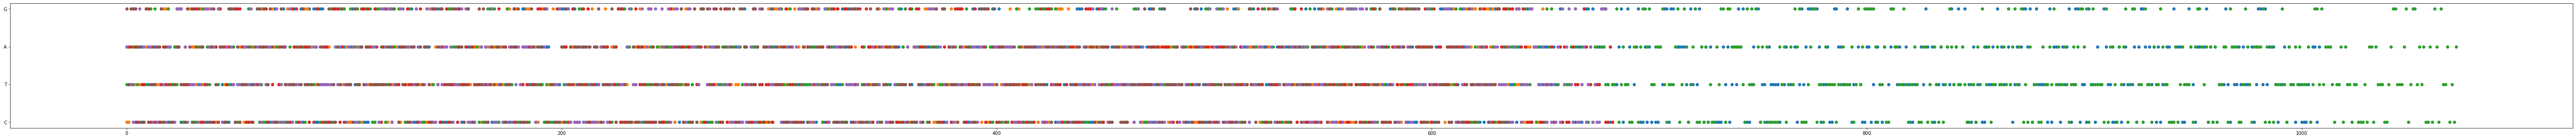

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file = SeqIO.parse('all_pisces_coi.fasta', 'fasta')

di = {}
for record in file:
    if(getGenbank(record.id).organism == 'Lethenteron camtschaticum'):
        di[len(record.seq)] = list(record.seq)
#print(di)

plt.figure(figsize = (100, 5))
for i in range(len(di.keys())):
    if i < 100:
        plt.plot(np.arange(list(di.keys())[i]), list(di.values())[i], 'o')
        #[220829_1404]CREATED 시퀀스 bp에 대한 염기를 그래프로 나타냄
plt.show()

## alignment 대신 GC함량 값으로 시퀀스 슬라이싱

### GC함량 최댓값 범위 확인

In [4]:
import pandas as pd
import numpy as np

file = SeqIO.parse('all_pisces_coi.fasta', 'fasta')

l = []
for record in file:
    l.append(len(record.seq))
k_gc = min(l)
print(k_gc)
print(np.std(l))
#[220805_1705]NOTED 길이가 가장 짧은 시퀀스의 bp를 k-mers의 k로 설정

gc_df = pd.DataFrame()
gc_df['start index'] = 0
gc_df['gc-contents'] = 0

file = SeqIO.parse('all_pisces_coi.fasta', 'fasta')

for i, record in enumerate(file):
    index = 0
    gc_rates = []
    while(index + k_gc <= len(record.seq)):
        mer = record.seq[index:index + k_gc]
        gc_rates.append(GC(mer))
        index += 1
    gc_df.loc[i, 'start index'] = gc_rates.index(max(gc_rates))
    #[220805_1706]NOTED GC함량이 가장 높은 mer의 시작 인덱스를 저장
    gc_df.loc[i, 'gc-contents'] = max(gc_rates)
    #[220805_1706]NOTED GC함량이 가장 높은 mer의 GC함량을 저장

391
167.310324188192


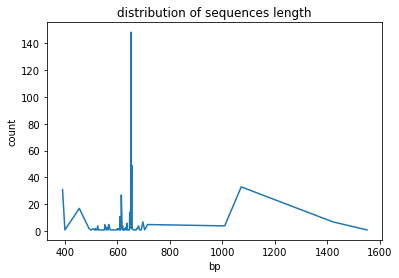

In [3]:
import matplotlib.pyplot as plt

x = sorted(set(l))
y = [l.count(x) for x in x]
plt.plot(x, y)
plt.title('distribution of sequences length')
plt.xlabel('bp')
plt.ylabel('count')
plt.show()
plt.close()

### 기존 데이터 슬라이싱 후 3-mer 적용

In [4]:
import pandas as pd
import numpy as np

file = SeqIO.parse('all_pisces_coi.fasta', 'fasta')

k = 3
dict = {}
df = pd.DataFrame()

#[220513_1700]CREATED AGCT 외의 염기를 처리하기 위해 사전형에 key, value로 저장 
base_dict = {'A':'A', 'G':'G', 'C':'C', 'T':'T', 'U':'U',
'Y':'T', 'R':'A', 'S':'C', 'W':'A', 'K':'G', 'M':'C', 'B':'C', 'D':'G', 'H':'T', 'V':'C', 'N':'A'}

#[220508_1735]CREATED k = 3인 kmer의 모든 경우의 수를 사전형에 미리 저장
def init(datatype):
    for i in range(4):
        for j in range(4):
            for k in range(4):
                datatype[list(base_dict.keys())[i] + list(base_dict.keys())[j] + list(base_dict.keys())[k]] = 0
    #[220509_1517]CREATED k-means는 unsupervised이지만, 여기서는 표본의 타겟을 ncbi에서부터 추출가능하므로 타겟 피처 생성
    datatype['GC-contents'] = 0
    datatype['target'] = 0
    
init(df)

for i, record in enumerate(file):
    init(dict)
    record.seq = record.seq[int(gc_df.loc[i, 'start index']): int(gc_df.loc[i, 'start index']) + k_gc]
    #[220805_1023]CREATED 최대 GC 값 범위로 기존 데이터 슬라이싱
    dict['GC-contents'] = gc_df.loc[i, 'gc-contents']
    #[220805_1025]CREATED 최대 GC 값 저장
    dict['target'] = getGenbank(record.id).organism
    
    index = 0
    
    if(len(record.seq) >= k):
        while(index + k <= len(record.seq)):
            mer = record.seq[index:index + k]
            for p in range(k):
                mer = mer.replace(mer[p], base_dict.get(mer[p]))
            dict[mer] += 1
            index += 1
    df.loc[i] = dict

In [4]:
df.groupby('target').count()

,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TGT,TCA,TCG,TCC,TCT,TTA,TTG,TTC,TTT,GC-contents
target,,,,,,,,,,,,,,,,,,,,,
Carcharodon carcharias,19,19,19,19,19,19,19,19,19,19,...,19,19,19,19,19,19,19,19,19,19
Centrolophus niger,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8
Entosphenus tridentatus,17,17,17,17,17,17,17,17,17,17,...,17,17,17,17,17,17,17,17,17,17
Isurus oxyrinchus,204,204,204,204,204,204,204,204,204,204,...,204,204,204,204,204,204,204,204,204,204
Lethenteron camtschaticum,52,52,52,52,52,52,52,52,52,52,...,52,52,52,52,52,52,52,52,52,52
Mitsukurina owstoni,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
Peprilus paru,34,34,34,34,34,34,34,34,34,34,...,34,34,34,34,34,34,34,34,34,34
Petromyzon marinus,49,49,49,49,49,49,49,49,49,49,...,49,49,49,49,49,49,49,49,49,49
Scomber japonicus,141,141,141,141,141,141,141,141,141,141,...,141,141,141,141,141,141,141,141,141,141


In [7]:
#[220811_1437]NOTED 9종으로 잘 크롤링되었음을 확인
df['target'].unique()

array(['Lethenteron camtschaticum', 'Entosphenus tridentatus',
       'Centrolophus niger', 'Carcharodon carcharias',
       'Scomber japonicus', 'Isurus oxyrinchus', 'Mitsukurina owstoni',
       'Petromyzon marinus', 'Peprilus paru'], dtype=object)

In [8]:
""" # row 생략 없이 출력
pd.set_option('display.max_rows', None)
# col 생략 없이 출력
pd.set_option('display.max_columns', None) """

df

,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TCA,TCG,TCC,TCT,TTA,TTG,TTC,TTT,GC-contents,target
0,5,2,12,9,2,7,6,5,12,0,...,6,1,9,9,12,8,9,19,100.0,Lethenteron camtschaticum
1,5,2,12,9,2,7,6,5,12,0,...,6,1,9,9,12,8,9,19,100.0,Lethenteron camtschaticum
2,5,2,12,9,2,7,6,5,12,0,...,6,1,9,9,12,8,9,19,100.0,Lethenteron camtschaticum
3,5,2,11,10,2,9,6,4,12,0,...,7,1,5,9,12,8,9,23,100.0,Entosphenus tridentatus
4,4,4,9,10,1,3,10,3,5,2,...,3,5,14,8,7,7,12,13,100.0,Centrolophus niger
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524,4,0,10,16,0,6,7,3,6,2,...,6,1,8,12,12,9,10,16,100.0,Peprilus paru
525,4,0,10,16,0,6,7,3,6,2,...,6,1,8,12,12,9,10,16,100.0,Peprilus paru
526,2,2,5,10,2,3,11,5,4,1,...,4,3,11,10,7,8,10,13,100.0,Isurus oxyrinchus
527,3,4,9,10,1,8,7,6,5,1,...,2,5,6,7,14,6,6,18,100.0,Petromyzon marinus


In [9]:
#[220509_1621]CREATED 레이블 인코딩으로 종 이름 -> 고유 숫자
from sklearn.preprocessing import LabelEncoder

a = df['target']
encoder = LabelEncoder()
labels = encoder.fit_transform(a)
#[220509_1622]NOTED* 종의 총 개수 = 19인 것을 알 수 있으므로 KMeans의 파라미터인 n_clusters를 14 -> 19로 수정
#[220513_1830]NOTED 종: 101개
#[220519_1745]NOTED 종: 9개
print(labels)

df['target'] = labels
df.head()

[4 4 4 2 1 0 0 0 0 8 8 8 8 1 0 3 3 3 3 3 3 3 3 3 3 5 7 7 7 7 8 8 3 0 0 0 0
 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 3 0 2 8 6 6 1 1 1 8 8 6 8 7 7 7 7 6 6 6 6 0 3 8 1 4 2 2 2 8
 8 8 4 4 4 4 4 4 4 4 4 4 8 0 3 3 3 3 3 8 8 8 8 8 2 4 4 4 4 4 7 7 7 7 7 7 7
 7 7 8 8 8 8 8 8 8 8 8 5 0 8 8 8 6 6 6 6 8 8 8 6 3 3 3 3 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 5 6 6 6 6 3 3 3 7 7 7 7 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 6 7 8 5 1 7
 7 3 3 3 3 3 3 3 3 3 1 0 5 7 7 7 7 7 7 7 7 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 8 8 8 8 8 8 8 8 8 8 8 8 8 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 8 8 8 8 8 8 3 8 8 8 8 8 8 8 8 8
 8 3 3 3 4 8 8 8 8 3 7 7 2 2 2 2 2 2 2 7 4 4 4 4 0 3 6 2 8 8 0 3 3 3 3 3 3
 3 3 3 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 3 3 3 3 6
 6 6 6 3 6 6 6 4 4 4 4 8 

,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TCA,TCG,TCC,TCT,TTA,TTG,TTC,TTT,GC-contents,target
0,5,2,12,9,2,7,6,5,12,0,...,6,1,9,9,12,8,9,19,100.0,4
1,5,2,12,9,2,7,6,5,12,0,...,6,1,9,9,12,8,9,19,100.0,4
2,5,2,12,9,2,7,6,5,12,0,...,6,1,9,9,12,8,9,19,100.0,4
3,5,2,11,10,2,9,6,4,12,0,...,7,1,5,9,12,8,9,23,100.0,2
4,4,4,9,10,1,3,10,3,5,2,...,3,5,14,8,7,7,12,13,100.0,1


In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
#[220805_1714]NOTED* GC함량을 정규화
scaler.fit(df['GC-contents'].array.reshape(-1, 1))
gc_scaled = scaler.transform(df['GC-contents'].array.reshape(-1, 1))
df['GC-contents'] = gc_scaled

In [11]:
df

,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TCA,TCG,TCC,TCT,TTA,TTG,TTC,TTT,GC-contents,target
0,5,2,12,9,2,7,6,5,12,0,...,6,1,9,9,12,8,9,19,0.0,4
1,5,2,12,9,2,7,6,5,12,0,...,6,1,9,9,12,8,9,19,0.0,4
2,5,2,12,9,2,7,6,5,12,0,...,6,1,9,9,12,8,9,19,0.0,4
3,5,2,11,10,2,9,6,4,12,0,...,7,1,5,9,12,8,9,23,0.0,2
4,4,4,9,10,1,3,10,3,5,2,...,3,5,14,8,7,7,12,13,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524,4,0,10,16,0,6,7,3,6,2,...,6,1,8,12,12,9,10,16,0.0,6
525,4,0,10,16,0,6,7,3,6,2,...,6,1,8,12,12,9,10,16,0.0,6
526,2,2,5,10,2,3,11,5,4,1,...,4,3,11,10,7,8,10,13,0.0,3
527,3,4,9,10,1,8,7,6,5,1,...,2,5,6,7,14,6,6,18,0.0,7


## SVM 모델 생성

In [12]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average = 'macro')
    recall = recall_score(y_test, pred, average = 'macro')
    
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.2f}, 정밀도: {1:.2f}, 재현율: {2:.2f}'.format(accuracy, precision, recall))
    
    
svm_2 = SVC(kernel = 'linear') 
#[220715_1739]NOTED 모델 생성

X = df.loc[:, 'AAA':'GC-contents']
y = df['target']

scaler = StandardScaler()
new_X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size = 0.2)
#[220715_1740]NOTED 학습 데이터와 테스트 데이어셋으로 무작위 분리한 뒤 정규화

parameters = {'C':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'gamma':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
#[220715_1741]NOTED 파라미터 후보 설정

grid_svm = GridSearchCV(svm_2, param_grid = parameters, cv = 5)
grid_svm.fit(X_train, y_train)  
#[220711_1658]NOTED 검증 데이터셋 + 학습 데이터셋 = 원래 학습 데이터셋

print(grid_svm.best_params_)
print(grid_svm.best_score_)
best_pred = grid_svm.best_estimator_.predict(X_test)
get_clf_eval(y_test, best_pred)

/Users/biosmu/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


{'C': 1, 'gamma': 1}
0.9952941176470589
오차 행렬
[[ 2  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0]
 [ 0  0 42  0  0  0  0  0]
 [ 0  0  0 13  0  0  0  0]
 [ 0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0 11  0]
 [ 0  0  0  0  0  0  0 25]]
정확도: 1.00, 정밀도: 1.00, 재현율: 1.00


## KMeans 모델의 최적 K값 구하기

### Elbow Method

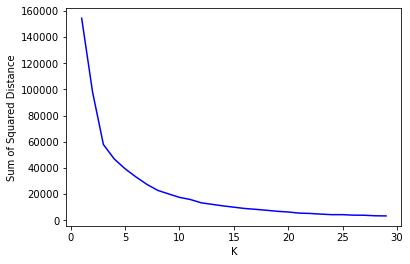

In [17]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

ks = range(1, 30)
sse = []
for k in ks:
    km = KMeans(n_clusters = k, max_iter = 5000)
    km.fit(df.iloc[:,:-1])
    sse.append(km.inertia_)

plt.plot(ks, sse, 'b')
plt.xlabel('K')
plt.ylabel('Sum of Squared Distance')
plt.show()
#[220805_1649]CREATED k = 6일 때가 최적 but 실제는 9

### Silhouette Method

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

ks = range(2, 20)
for k in ks:
    kmeans = KMeans(n_clusters = k, max_iter=5000)
    kmeans.fit(df.iloc[:,:-1])
    df['cluster'] = kmeans.labels_
    df['sil_sam'] = silhouette_samples(df.iloc[:, :-2], df['cluster'])
    #[220805_1651]NOTED silhouette_samples: 점의 실루엣 계수
    sil_tot = silhouette_score(df.iloc[:, :-3], df['cluster'])
    #[220805_1652]NOTED silhouette_score: 전체의 실루엣 계수
    sil_clu = df.groupby('cluster')['sil_sam'].mean()
    score_k = np.mean([abs(i - sil_tot) for i in sil_clu])
    print('전체 실루엣 계수 평균: {0:.3f}\n군집 별 실루엣 계수 평균: \n{1}'.format(sil_tot, sil_clu))
    print('score: {0:.3f}'.format(score_k))
    #[220805_1712]NOTED 전체 실루엣 계수와 군집 별 실루엣 계수 간의 편차의 제곱을 구하여 성능 지표로 활용
    print('---------------')
    df.drop('cluster', axis = 1, inplace = True)
    df.drop('sil_sam', axis = 1, inplace = True)
    #[220811_1518]NOTED k = 10일 때 최적 but 실제는 9

전체 실루엣 계수 평균: 0.447
군집 별 실루엣 계수 평균: 
cluster
0    0.273676
1    0.668280
Name: sil_sam, dtype: float64
score: 0.197
---------------
전체 실루엣 계수 평균: 0.521
군집 별 실루엣 계수 평균: 
cluster
0    0.294323
1    0.658591
2    0.715777
Name: sil_sam, dtype: float64
score: 0.186
---------------
전체 실루엣 계수 평균: 0.619
군집 별 실루엣 계수 평균: 
cluster
0    0.287417
1    0.811883
2    0.655150
3    0.567904
Name: sil_sam, dtype: float64
score: 0.153
---------------
전체 실루엣 계수 평균: 0.661
군집 별 실루엣 계수 평균: 
cluster
0    0.804990
1    0.655150
2    0.536945
3    0.349311
4    1.000000
Name: sil_sam, dtype: float64
score: 0.185
---------------
전체 실루엣 계수 평균: 0.735
군집 별 실루엣 계수 평균: 
cluster
0    0.242076
1    0.630089
2    0.759760
3    0.838329
4    1.000000
5    0.595229
Name: sil_sam, dtype: float64
score: 0.188
---------------
전체 실루엣 계수 평균: 0.788
군집 별 실루엣 계수 평균: 
cluster
0    0.432951
1    0.678756
2    0.759760
3    1.000000
4    0.808999
5    0.535193
6    1.000000
Name: sil_sam, dtype: float64
score: 0.170
--------------

/var/folders/k8/6ll3wmpx4pb47d31hygxs_j80000gn/T/ipykernel_47773/596326150.py:8: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  kmeans.fit(df.iloc[:,:-1])


전체 실루엣 계수 평균: 0.998
군집 별 실루엣 계수 평균: 
cluster
0     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
11    1.0
12    1.0
13    0.0
14    1.0
Name: sil_sam, dtype: float64
score: 0.073
---------------


/var/folders/k8/6ll3wmpx4pb47d31hygxs_j80000gn/T/ipykernel_47773/596326150.py:8: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  kmeans.fit(df.iloc[:,:-1])


전체 실루엣 계수 평균: 0.998
군집 별 실루엣 계수 평균: 
cluster
1     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
11    1.0
12    1.0
13    0.0
14    1.0
Name: sil_sam, dtype: float64
score: 0.073
---------------


/var/folders/k8/6ll3wmpx4pb47d31hygxs_j80000gn/T/ipykernel_47773/596326150.py:8: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (17). Possibly due to duplicate points in X.
  kmeans.fit(df.iloc[:,:-1])


전체 실루엣 계수 평균: 0.998
군집 별 실루엣 계수 평균: 
cluster
0     1.0
1     1.0
2     1.0
3     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
11    1.0
12    1.0
13    0.0
14    1.0
Name: sil_sam, dtype: float64
score: 0.073
---------------


/var/folders/k8/6ll3wmpx4pb47d31hygxs_j80000gn/T/ipykernel_47773/596326150.py:8: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (18). Possibly due to duplicate points in X.
  kmeans.fit(df.iloc[:,:-1])


전체 실루엣 계수 평균: 0.998
군집 별 실루엣 계수 평균: 
cluster
0     1.0
1     1.0
2     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
11    1.0
12    1.0
13    0.0
14    1.0
Name: sil_sam, dtype: float64
score: 0.073
---------------


KeyboardInterrupt: 

## K-means 모델 생성

In [10]:
def cal_accuracy(target, cluster):
    ct = pd.crosstab(target, cluster)
    accuracy = 0
    for i in range(ct.iloc[:, 0].count()):
        accuracy += ct.iloc[i,:].max() / ct.iloc[i,:].sum()
    return accuracy / ct.iloc[:, 0].count()
#[220812_1340]CREATED 비지도학습에서의 정확도 계산 함수 생성

### 교차 검증

* 검증 데이터셋 생성x(학습 데이터량의 변화에 따른 모델의 정확도 변화 분석에 용이)

In [13]:
from sklearn.cluster import KMeans
data = df.iloc[:,:-1]
label = df['target']
#[220812_1141]CREATED 교차 검증을 위한 모델, 데이터, 라벨 생성
cv = 1
#[220812_2338]NOTED 검증 데이터셋 개수
start_index = 0
accuracy = []
for i in range(cv):
    X_test = data.iloc[start_index:start_index + len(df.index) // cv]
    y_test = label[start_index:start_index + len(df.index) // cv]
    kmeans = KMeans(n_clusters = len(y_test.unique()), max_iter = 1000)
    kmeans.fit(X_test)
    accuracy.append(np.round(cal_accuracy(y_test, kmeans.labels_), 4))
    #[220812_2338]CREATED crosstab에 새로운 데이터를 넣을 때는 리스트로 넣기
    start_index += (len(df.index) // cv)
print('교차 검증별 정확도:', accuracy)
print('평균 검증 정확도:', np.round(np.mean(accuracy), 4))
#[220813_1117]NOTED 검증 데이터셋이 없고, 학습 데이터셋의 수는 cv값과 반비례하기 때문에, cv값이 증가함에 따라 정확도는 감소
#[220813_1117]NOTED 학습 데이터 수가 줄어듬에 따라 모델의 정확도 변화율을 분석하기에 용이

교차 검증별 정확도: [0.8114]
평균 검증 정확도: 0.8114


* 검증 데이터셋 생성

In [82]:
from sklearn.cluster import KMeans
data = df.iloc[:,:-1]
label = df['target']
#[220812_1141]CREATED 교차 검증을 위한 모델, 데이터, 라벨 생성
cv = 5
#[220812_2338]NOTED 검증 데이터셋 개수
start_index = 0
accuracy = []
for i in range(cv):
    X_train, X_test = pd.concat([data.iloc[0:start_index], data.iloc[start_index + len(df.index) // cv:]]), data.iloc[start_index:start_index + len(df.index) // cv]
    y_train, y_test = pd.concat([label[0:start_index], label[start_index + len(df.index) // cv:]]), label[start_index:start_index + len(df.index) // cv] 
    #[220813_1108]CREATED X_test, y_test: 검증 데이터셋
    kmeans = KMeans(n_clusters = len(y_train.unique()), max_iter = 1000)
    kmeans.fit(X_train)
    accuracy.append(np.round(cal_accuracy(y_train, kmeans.labels_), 4))
    #[220812_2338]CREATED crosstab에 새로운 데이터를 넣을 때는 리스트로 넣기
    #[220813_1108]CREATED predict()를 통해 새로운 데이터셋에 대한 cluster 레이블을 출력하여 정답지인 y_test와 비교한다.
    start_index += (len(df.index) // cv)
print('교차 검증별 정확도:', accuracy)
print('평균 검증 정확도:', np.round(np.mean(accuracy), 4))

교차 검증별 정확도: [0.9012, 0.8898, 0.8839, 0.9175, 0.8591]
평균 검증 정확도: 0.8903


## 차원 축소 및 데이터 분포 확인

In [14]:
km = KMeans(n_clusters = 13, max_iter = 1000)
km.fit(df.iloc[:,:-1])
df['cluster'] = km.labels_

In [296]:
df.drop('pca_z', axis = 1, inplace = True)
df.drop('pca_x', axis = 1, inplace = True)
df.drop('pca_y', axis = 1, inplace = True)
df.drop('cluster', axis = 1, inplace = True)

In [15]:
df

,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TCG,TCC,TCT,TTA,TTG,TTC,TTT,GC-contents,target,cluster
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,4,6
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,4,6
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,4,6
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,2,6
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,6,7
525,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,6,7
526,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,3,1
527,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,7,3


In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 3)
pca_transformed = pca.fit_transform(df.iloc[:, :-2])

df['pca_x'] = pca_transformed[:, 0]
df['pca_y'] = pca_transformed[:, 1]
df.head()

,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TCT,TTA,TTG,TTC,TTT,GC-contents,target,cluster,pca_x,pca_y
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,4,6,-0.252371,-0.090951
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,4,6,-0.252371,-0.090951
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,4,6,-0.252371,-0.090951
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,2,6,-0.252371,-0.090951
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,1,6,-0.252371,-0.090951


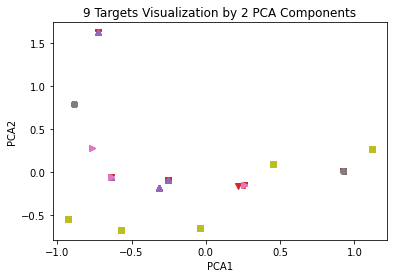

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

marker_ind = []
for i in range(9):
    marker_ind.append(df[df['target'] == i].index)
marker = ['.', ',', 'o', 'v', '^', '<', '>', '8', 's', 'p']
for i, j in zip(marker, marker_ind):
    plt.scatter(x = df.loc[j, 'pca_x'], y = df.loc[j, 'pca_y'], marker = i)

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('9 Targets Visualization by 2 PCA Components')
plt.show()

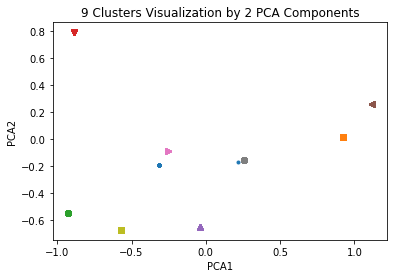

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

marker_ind = []
for i in range(9):
    marker_ind.append(df[df['cluster'] == i].index)
marker = ['.', ',', 'o', 'v', '^', '<', '>', '8', 's', 'p']
for i, j in zip(marker, marker_ind):
    plt.scatter(x = df.loc[j, 'pca_x'], y = df.loc[j, 'pca_y'], marker = i)
    
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('9 Clusters Visualization by 2 PCA Components')
plt.show()

In [21]:
print(cal_accuracy(df['target'], df['cluster']))

0.7942745598732404


In [29]:
km2 = KMeans(n_clusters = 13, max_iter = 1000)
km2.fit(df.iloc[:,:-1])
cal_accuracy(df['target'], km2.labels_)

0.7942745598732404